In [27]:
import pandas as pd
import numpy as np
import os
import pickle
import torch
import sys

sys.path.append('../')
from src.helpers import *
from src.visualize import *
from src.trainer import *
from src.trainer_hnet import * 
from src.helpers_task_detector import *
from Models.models import *

In [28]:
experiment_name = 'Experiment1'
path_results = './Results/' + experiment_name

In [29]:
with open(os.path.join(path_results +'.pkl'), 'rb') as fp:
    results = pickle.load(fp)

In [30]:
results['Data_0_1'].keys()

dict_keys(['predicted_task', 'new_task', 'detector_train_losses', 'detector_val_losses', 'y_true_detector', 'y_pred_detector', 'r2_test_detector', 'y_true_hnet', 'y_pred_hnet', 'r2_test_hnet', 'hnet_train_losses', 'hnet_val_losses'])

In [31]:
dataset = []
r2_test_detector = []
r2_test_hnet = []
y_true_detector = []
y_pred_detector = []
y_true_hnet = []
y_pred_hnet = []

with open(os.path.join(path_results +'.pkl'), 'rb') as fp:
    results = pickle.load(fp)
    for set in results.keys():
        dataset.append(set)
        r2_test_detector.append(results[set]['r2_test_detector'])
        r2_test_hnet.append(results[set]['r2_test_hnet'])
        if 'y_true_hnet' in results[set].keys():
            y_true_hnet.append([results[set]['y_true_hnet']])
            y_pred_hnet.append([results[set]['y_pred_hnet']])
        else:
            y_true_hnet.append([0])
            y_pred_hnet.append([0])
        if 'y_true_detector' in results[set].keys():
            y_true_detector.append([results[set]['y_true_detector']])
            y_pred_detector.append([results[set]['y_pred_detector']])
        else:
            y_true_detector.append([0])
            y_pred_detector.append([0])

In [32]:
df = pd.DataFrame({'Dataset':dataset,
                    'Y_t_detector': y_true_detector,
                    'Y_p_detector':y_pred_detector,  
                    'R2_Detector':r2_test_detector,
                    'Y_t_hnet': y_true_hnet,
                    'Y_p_hnet':y_pred_hnet,  
                    'R2_hnet':r2_test_hnet})

In [33]:
df

,Dataset,Y_t_detector,Y_p_detector,R2_Detector,Y_t_hnet,Y_p_hnet,R2_hnet
0,Data_0_1,"[[[-0.106160894, 0.16044481], [0.08029461, -0....","[[[0.6246227, -0.8454965], [0.61250055, -0.530...",0.871277,"[[[[-0.1061609 0.16044482], [ 0.08029461 -0....","[[[[-1.2226496 0.23670873], [1.9218637 0.19...",0.825989
1,Data_0_2,[0],[0],0.867776,"[[[[-0.1061609 0.16044482], [ 0.08029461 -0....","[[[[-0.10885167 -1.4230759 ], [ 0.6837431 -0....",0.821806
2,Data_1_1,"[[[-0.106160894, 0.16044481], [0.08029461, -0....","[[[0.18519881, -0.5830423], [0.459361, -0.3222...",0.863727,"[[[[-0.1061609 0.16044482], [ 0.08029461 -0....","[[[[-0.77672833 -0.27633694], [-0.5463041 -2.5...",0.798148
3,Data_1_2,[0],[0],0.865941,"[[[[0.20469173 0.27441731], [0.20378454 0.2297...","[[[[ 0.8753853 -0.8860687], [0.48364425 0.8199...",0.796693
4,Data_2_1,"[[[-0.106160894, 0.16044481], [0.08029461, -0....","[[[0.42714936, -1.2525126], [0.5811763, -1.096...",0.873758,"[[[[-0.1061609 0.16044482], [ 0.08029461 -0....","[[[[1.3842869 0.47931418], [ 0.8954248 -1.433...",0.814240
5,Data_2_2,[0],[0],0.862860,"[[[[0.20469173 0.27441731], [0.20378454 0.2297...","[[[[-0.19888026 -3.3028715 ], [0.44017047 0.51...",0.821466
6,Data_3_1,"[[[-0.106160894, 0.16044481], [0.08029461, -0....","[[[0.5463887, -1.5822499], [0.19791111, -0.840...",0.852042,"[[[[-0.1061609 0.16044482], [ 0.08029461 -0....","[[[[-0.75575763 0.22842765], [1.2771637 0.06...",0.804023
7,Data_3_2,[0],[0],0.810858,"[[[[0.20469173 0.27441731], [0.20378454 0.2297...","[[[[ 0.61996114 -0.59940946], [ 0.13161373 -0....",0.827988
8,Data_4_1,"[[[-0.106160894, 0.16044481], [0.08029461, -0....","[[[0.081935704, -1.3537786], [0.1999526, -0.98...",0.858449,"[[[[-0.1061609 0.16044482], [ 0.08029461 -0....","[[[[1.152723 0.05039352], [0.85703516 0.4435...",0.809617
9,Data_4_2,[0],[0],0.849488,"[[[[0.20469173 0.27441731], [0.20378454 0.2297...","[[[[-0.9491283 0.12286979], [0.71397066 0.14...",0.827547


### Assess continual learning on hypernetwork

The idea here is to load all hypernets, after each task has been learned, and then test for each model on the trained task + all the previously seen tasks.

In [34]:
path_to_hnets = './Models/Models_HNET'
data_path = './Data/Detector_Datasets_Chewie_1007.pkl'

models_exp = np.sort(os.listdir(os.path.join(path_to_hnets, experiment_name)))

with open(os.path.join(data_path), 'rb') as fp:
    data = pickle.load(fp)

In [35]:
model = []
test_set = []
r2_list = []
for i,m in enumerate(models_exp):
    model_i = torch.load(os.path.join(path_to_hnets,experiment_name, m))
    print(model_i)
    for ind_k,k in enumerate(data.keys()):
        data_index = int(k.split("_")[1])
        if data_index <= i:
            W = model_i(cond_id = data_index)
            main_net = RNN_Main_Model(num_features= 130, hnet_output = W,  hidden_size = 300,
                                num_layers= 1,out_dims=2,  
                                dropout= 0.2,  LSTM_ = False)
            x_train, y_train, x_val, y_val, x_test, y_test = data[k]
            r2, _ = calc_explained_variance_mnet(x_test, y_test, W, main_net)

            model.append(m)
            test_set.append(k)
            r2_list.append(r2)


Hypernetwork with 1823425 weights and 130202 outputs (compression ratio: 14.00).
The network consists of 1822945 unconditional weights (1822945 internally maintained) and 480 conditional weights (480 internally maintained).
Hypernetwork with 1823425 weights and 130202 outputs (compression ratio: 14.00).
The network consists of 1822945 unconditional weights (1822945 internally maintained) and 480 conditional weights (480 internally maintained).
Hypernetwork with 1823425 weights and 130202 outputs (compression ratio: 14.00).
The network consists of 1822945 unconditional weights (1822945 internally maintained) and 480 conditional weights (480 internally maintained).
Hypernetwork with 1823425 weights and 130202 outputs (compression ratio: 14.00).
The network consists of 1822945 unconditional weights (1822945 internally maintained) and 480 conditional weights (480 internally maintained).
Hypernetwork with 1823425 weights and 130202 outputs (compression ratio: 14.00).
The network consists of

In [36]:
df = pd.DataFrame({'Model':model,
                   'Dataset':test_set,
                    'R2': r2_list})

/tmp/ipykernel_219773/1176930008.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Model', y='R2', hue='Dataset', ci=None)  # ci=None to remove confidence intervals


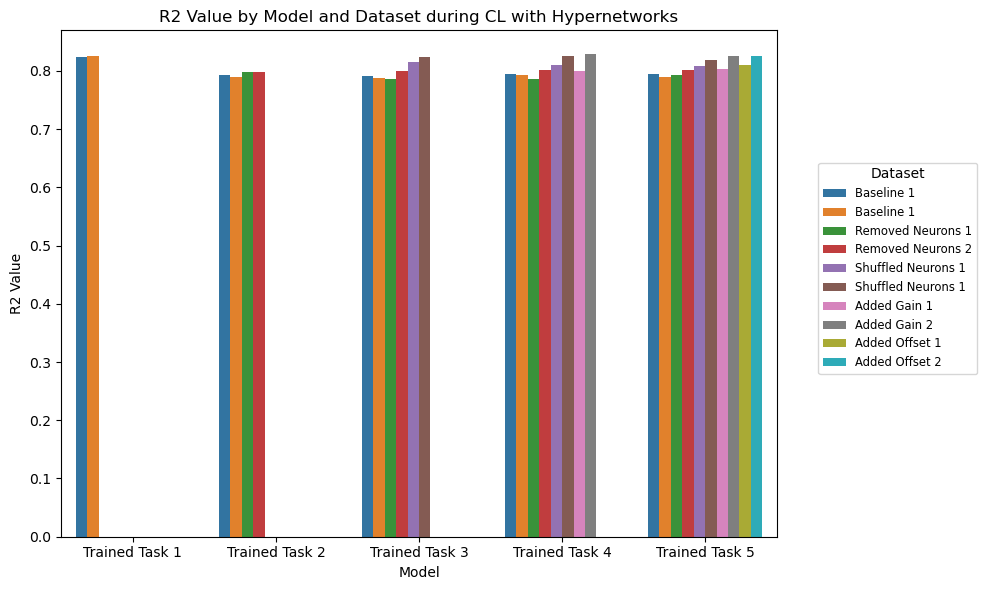

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your data is stored in a pandas DataFrame called 'df'
# df = pd.DataFrame({'model': ..., 'dataset': ..., 'r2': ...})

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Model', y='R2', hue='Dataset', ci=None)  # ci=None to remove confidence intervals
plt.title('R2 Value by Model and Dataset during CL with Hypernetworks')
plt.xlabel('Model')
plt.ylabel('R2 Value')
new_labels = ['Trained Task 1', 'Trained Task 2', 'Trained Task 3', 'Trained Task 4', 'Trained Task 5']  # New labels for x-axis
plt.xticks(ticks=range(len(new_labels)), labels=new_labels)
#plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
legend_labels = ['Baseline 1', 'Baseline 1', 'Removed Neurons 1', 'Removed Neurons 2',
                 'Shuffled Neurons 1', 'Shuffled Neurons 1', 'Added Gain 1', 'Added Gain 2',
                 'Added Offset 1', 'Added Offset 2']  # New labels for legend

plt.legend(title='Dataset', fontsize = 'small', bbox_to_anchor=(1.05, 0.75), loc='upper left',  labels=legend_labels)  # Move legend to upper left corner
plt.tight_layout()
plt.show()
